# Отборочное соревнование на стажировку в области ML

Необходимо построить модель для прогнозирования оттока клиентов банка. Данные основаны на реальных признаках клиентов, однако для целей соревнования использован синтетический датасет, сгенерированный нейронной сетью на основе реальных распределений.
 

train.csv - обучающий набор данных; Exited является бинарной целью \
test.csv — тестовый набор данных; ваша задача — предсказать вероятность Exited \
sample_submission.csv — образец файла для отправки в правильном формате

### План выполнения

1. [Загрузка данных](#task_1) <a id='task_1_plan'></a>
    - Пропущенные значения
    - Неправильные типы данных
    - Неправильные значения категорий

2. [Предобработка данных](#task_2) <a id='task_2_plan'></a>
    - Поиск дубликатов

3. [Исследовательский анализ данных](#task_3) <a id='task_3_plan'></a>
    - Распределение признаков
    - Поиск выбросов и аномалий
    - Что влияет на большой и малый объём запасов в скважине?
    - Корреляционный анализ

4. [Подготовка данных и обучение моделей](#task_4) <a id='task_4_plan'></a>
    - Пайплайн для подготовки данных
    - Обучение моделей для каждого региона
    - Анализ остатков
    - Анализ важности признаков

### Описание данных

- `Customer ID`: Уникальный идентификатор клиента  
- `Surname`: Фамилия клиента  
- `CreditScore`: Кредитный рейтинг клиента (числовое значение)  
- `Geography`: Страна проживания клиента (Франция, Испания или Германия)  
- `Gender`: Пол клиента (Мужчина или Женщина)  
- `Age`: Возраст клиента  
- `Tenure`: Сколько лет клиент является клиентом банка  
- `Balance`: Баланс на счету клиента  
- `NumOfProducts`: Количество банковских продуктов, которыми пользуется клиент (например, сберегательный счёт, кредитная карта)  
- `HasCrCard`: Есть ли у клиента кредитная карта (1 = да, 0 = нет)  
- `IsActiveMember`: Является ли клиент активным пользователем (1 = да, 0 = нет)  
- `EstimatedSalary`: Примерная зарплата клиента  
- **`Exited`: Ушёл ли клиент из банка (Целевой признак)**

### [Загрузка данных](#task_1_plan) <a id='task_1'></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

In [4]:
# Информация о таблице, наличие пропусков 
def get_dataset(path, sep):
    df = pd.read_csv(path, sep=sep)
    display(df.head())
    df.info()
    display((df.isna().mean() * 100).sort_values(ascending=False).to_frame(name='пропуски_%'))
    return df

In [5]:
# Проверка наличия директории 
def check_dataset(path0, path1, sep):
    if os.path.exists(path0):
        return get_dataset(path0, sep)
    elif os.path.exists(path1):
        return get_dataset(path0, sep)
    else:
        print('неправильный путь к файлу')

In [6]:
path0 = './datasets/train.csv'
path1 = '/kaggle/input/webbee-internship-2025/train.csv' # директория для kagle 

train_customer_churn = check_dataset(path0, path1, sep=',')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15648047.0,Macleod,554.0,France,Female,32.0,3.0,98649.55,1.0,0.0,1.0,177099.71,0.0
1,1,15664681.0,Nnachetam,710.0,France,Male,38.0,9.0,0.00,2.0,0.0,0.0,141872.05,0.0
2,2,15762605.0,Zikoranachidimma,603.0,France,Female,38.0,9.0,136622.42,1.0,1.0,1.0,90212.38,0.0
3,3,15674750.0,Clements,710.0,France,Female,35.0,8.0,0.00,2.0,1.0,0.0,148811.81,0.0
4,4,15706463.0,Pinto,678.0,France,Male,34.0,8.0,0.00,2.0,0.0,0.0,148528.24,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


,пропуски_%
id,0.0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0


Тренировочный датасет имеет 15000 наблюдений, отсутсвуют пропуски. Столбец `id` необходимо перевести в индекс таблицы.

In [7]:
path0 = './datasets/test.csv'
path1 = '/kaggle/input/webbee-internship-2025/test.csv' # директория для kagle 

test_customer_churn = check_dataset(path0, path1, sep=',')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15632848.0,Teng,537.0,Spain,Male,27.0,8.0,119027.28,1.0,1.0,0.0,129964.14
1,15001,15797733.0,Onwuamaeze,646.0,France,Male,41.0,6.0,0.00,2.0,1.0,0.0,158523.02
2,15002,15662085.0,Eluemuno,683.0,France,Female,37.0,9.0,0.00,2.0,1.0,0.0,120892.96
3,15003,15744109.0,Hsing,717.0,France,Male,21.0,5.0,0.00,2.0,1.0,1.0,169781.45
4,15004,15635598.0,Calabrese,662.0,Germany,Male,45.0,4.0,121152.05,1.0,1.0,0.0,116286.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   CustomerId       10000 non-null  float64
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  float64
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  float64
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  float64
 10  HasCrCard        10000 non-null  float64
 11  IsActiveMember   10000 non-null  float64
 12  EstimatedSalary  10000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1015.8+ KB


,пропуски_%
id,0.0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0


Тестовый датасет имеет 10000 наблюдений, отсутсвуют пропуски.

### [Предобработка данных](#task_2_plan) <a id='task_2'></a>

In [8]:
print('Количество неявных дубликатов:', train_customer_churn.duplicated(subset=train_customer_churn.columns[2:]).sum())

Количество неявных дубликатов: 0


В тренировочном датасете отсутсвуют дубликаты.

In [9]:
train_customer_churn.set_index('id', inplace=True)
test_customer_churn.set_index('id', inplace=True)

Столбец `id` был переведен в индекс таблицы.

### [Исследовательский анализ](#task_3_plan) <a id='task_3'></a>

#### Распределение признаков

In [10]:
# Функция для отображения гистограммы всех признаков
def plt_hist(df):
    plt.figure(figsize=(22, 15))
    i = 1
    cols = df.columns[1:]
    
    for clm_n in cols:
        plt.subplot(4, 3, i)
        if df[clm_n].nunique() <= 20:
            axes = sns.countplot(data=df.iloc[:, 1:], x=clm_n, color='#1F77B4') 
        elif pd.api.types.is_numeric_dtype(df[clm_n]):
            axes = sns.kdeplot(data=df.iloc[:, 1:], x=clm_n, multiple="stack", bw_method=0.1)
        else:
            continue
        axes.set_ylabel('количество')
        i += 1

In [11]:
train_customer_churn.iloc[:, 1:].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000
mean,658.001000,37.737400,5.077600,42918.259637,1.589933,0.778400,0.484867,1.177050e+05,0.200133
std,73.498209,8.153809,2.794083,59874.716430,0.530218,0.415337,0.499788,4.713009e+04,0.400113
min,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.158000e+01,0.000000
25%,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,8.305543e+04,0.000000
50%,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,1.235473e+05,0.000000
75%,709.000000,42.000000,7.000000,111064.280000,2.000000,1.000000,1.000000,1.564371e+05,0.000000
max,850.000000,74.000000,10.000000,205770.780000,4.000000,1.000000,1.000000,1.557651e+06,1.000000


In [12]:
train_customer_churn.describe(exclude='number')

,Surname,Geography,Gender
count,15000,15000,15000
unique,767,3,2
top,Ch'iu,France,Male
freq,270,8990,8477


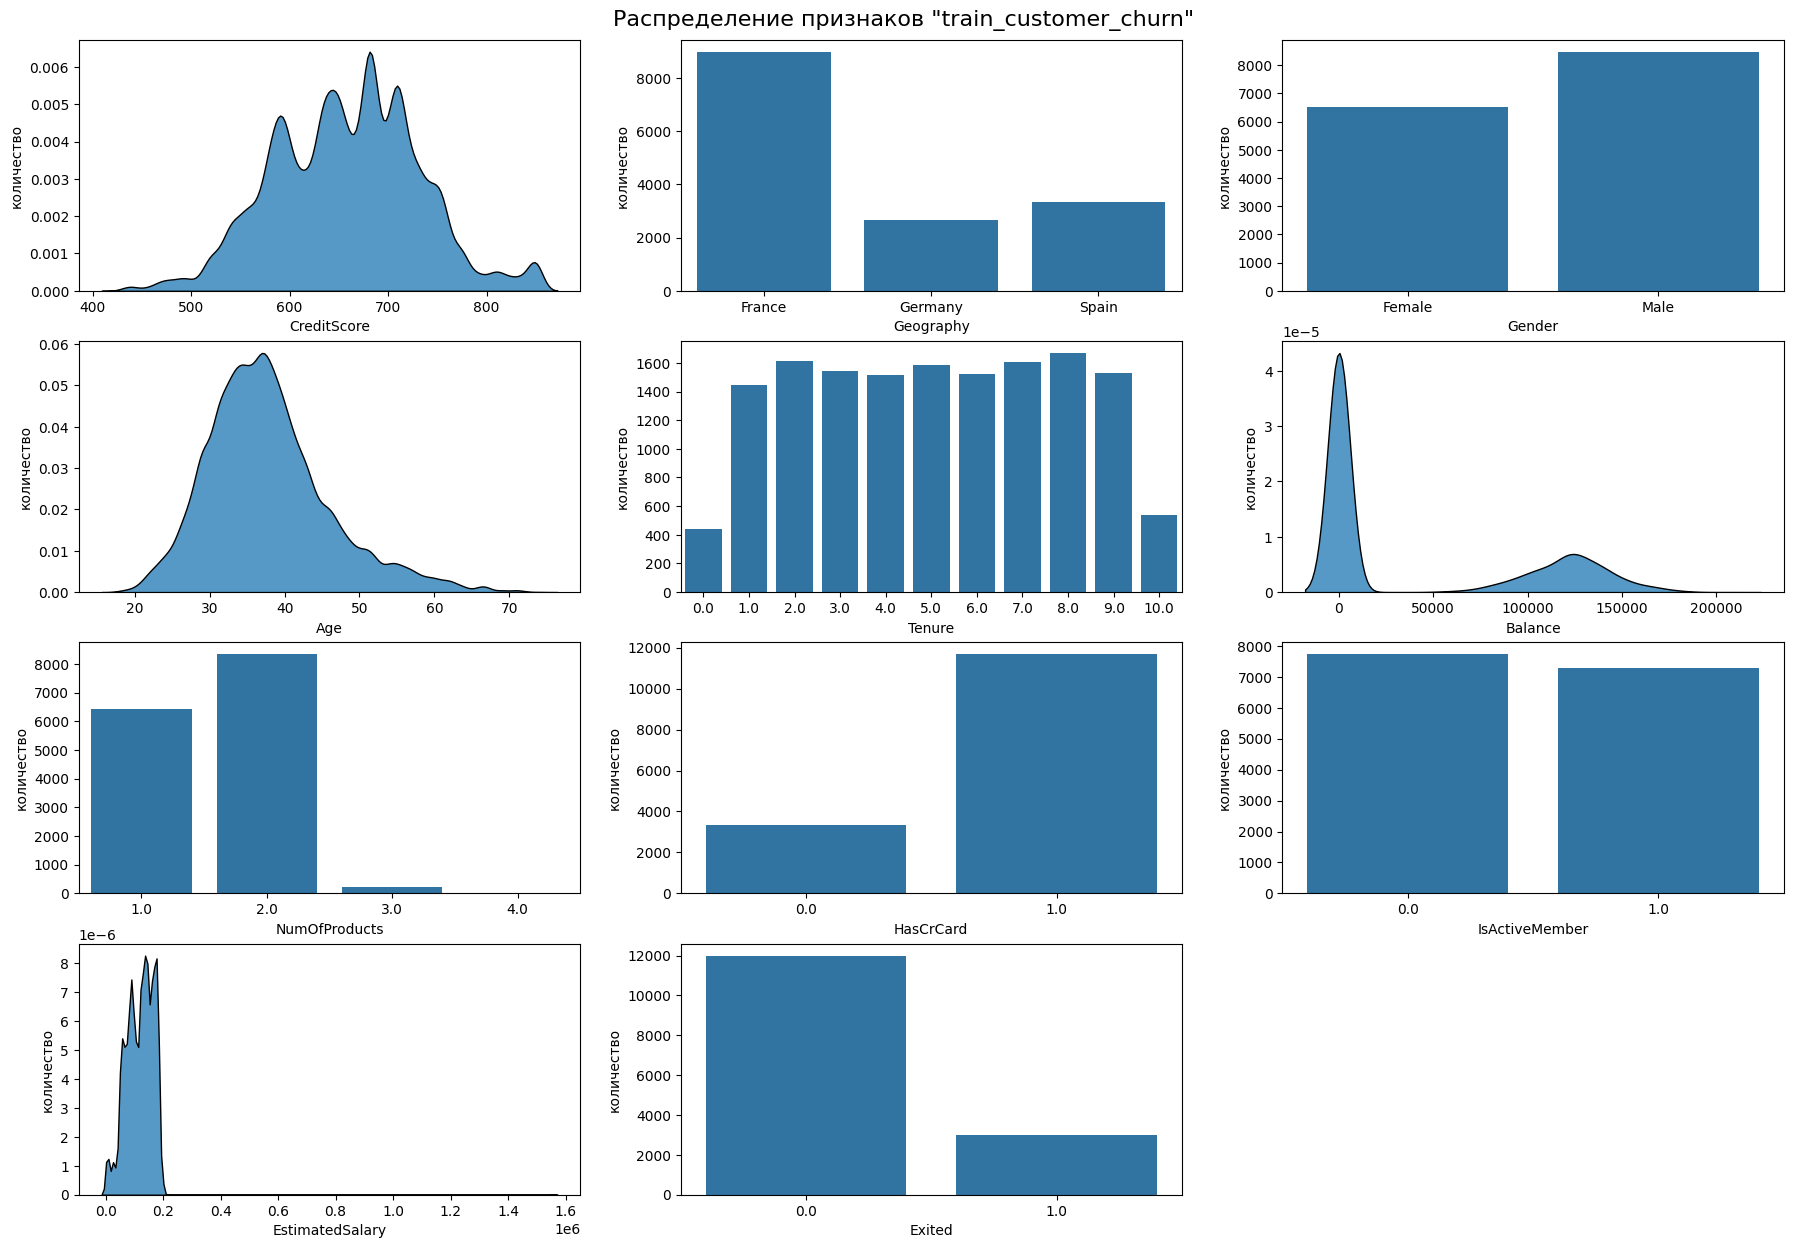

In [13]:

plt_hist(train_customer_churn)
plt.suptitle('Распределение признаков "train_customer_churn"', fontsize=16,y=0.9)
plt.show()

Чаще всего страной проживания клиента является Франция. \
Мужчины составляют незначительное большинство среди клиентов банка - 57%. \
Средний возраст клиентов банка - 37 лет. Основная клиентская база 32-42 года, тогда как младшие и старшие возрастные группы представлены незначительно. \
Клиенты с длительностью обслуживания 1-9 лет распределены равномерно. При этом новые (до года) и десятилетние клиенты встречаются реже. \
Баланс пользователей распределен бимодально. В большей степени клиенты не хранят денежные средства на счетах. \
Очень редко клиенты имеют более двух банковских продуктов. \
78% клиентов имеют кредитную карту. Активные и неактивные клиенты представлены примерно в равной пропорции. \
Признак с заработной платой имеет большой выброс. \
Целевой признак имеет явный дисбаланс классов.



#### Удаление выбросов и аномалий

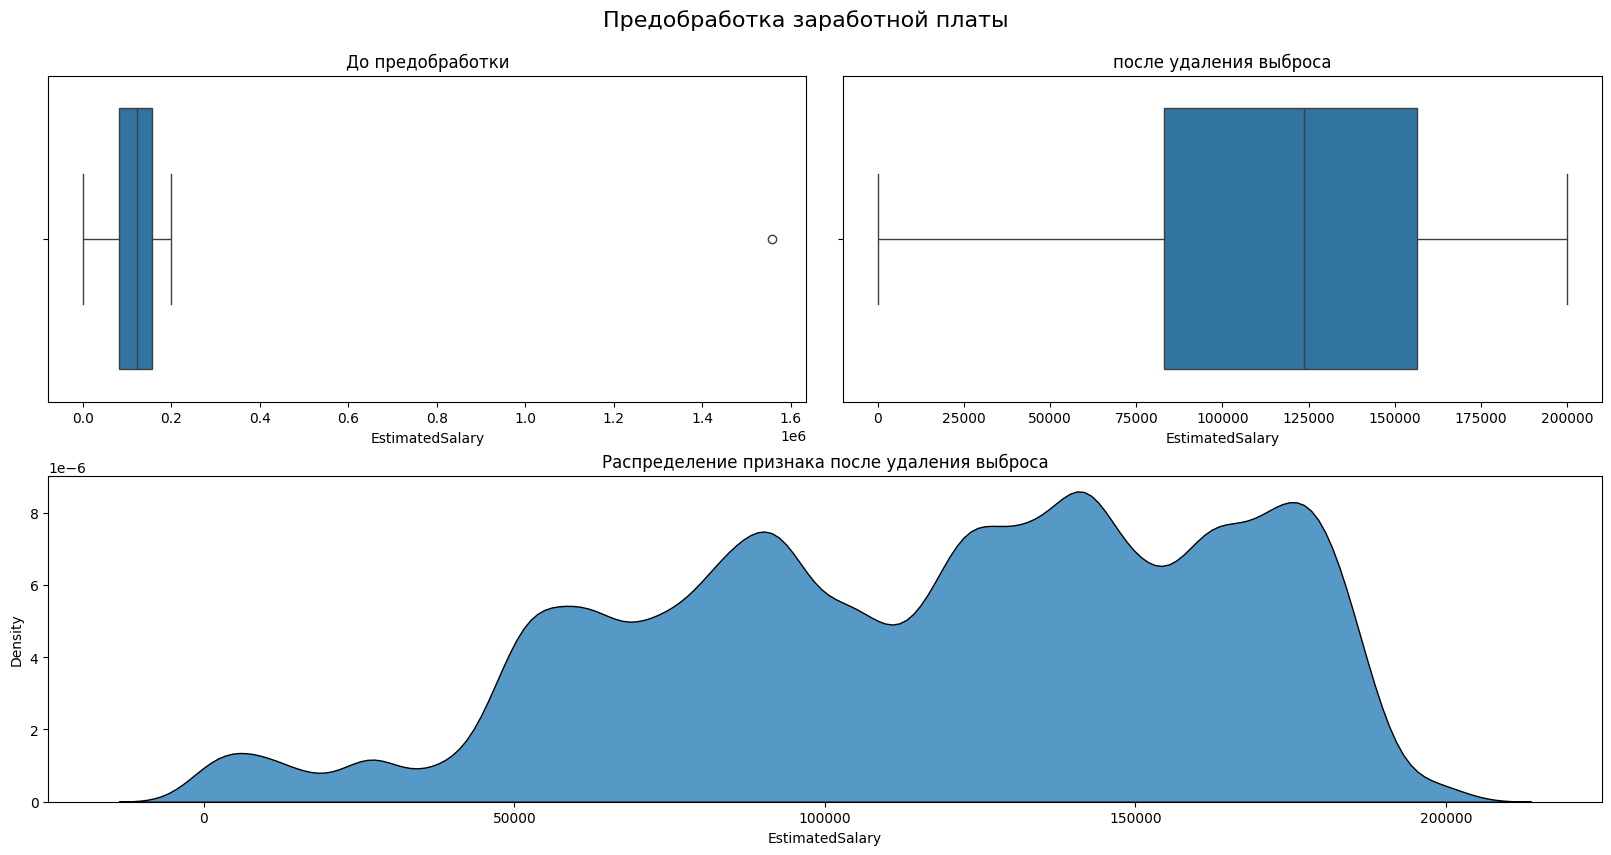

In [14]:
fg = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = fg.add_gridspec(2, 2)
plt.suptitle('Предобработка заработной платы', fontsize=16, y=1.05)

fig_ax_1 = fg.add_subplot(gs[0, 0])
plt.title('До предобработки')
sns.boxplot(train_customer_churn['EstimatedSalary'], orient='h')

train_customer_churn.query('EstimatedSalary < 1.5e6', inplace=True)
train_customer_churn.reset_index(drop=True, inplace=True)

fig_ax_2 = fg.add_subplot(gs[0, 1])
plt.title('после удаления выброса')
sns.boxplot(train_customer_churn['EstimatedSalary'], orient='h')

fig_ax_3 = fg.add_subplot(gs[1, :])
plt.title('Распределение признака после удаления выброса')
sns.kdeplot(data=train_customer_churn, x='EstimatedSalary', multiple="stack", bw_method=0.1)

plt.show()

Выброс заработной платы, равный 1557651, был удален фильтром. Некоторые сотрудники имеют заработную плату близкую к 0.

#### Какие клиенты не хранят деньги на счету в банке?

In [15]:
print('Количество клиентов, не имеющих денег на балансе:', train_customer_churn.query('Balance == 0').shape[0])

Количество клиентов, не имеющих денег на балансе: 9739


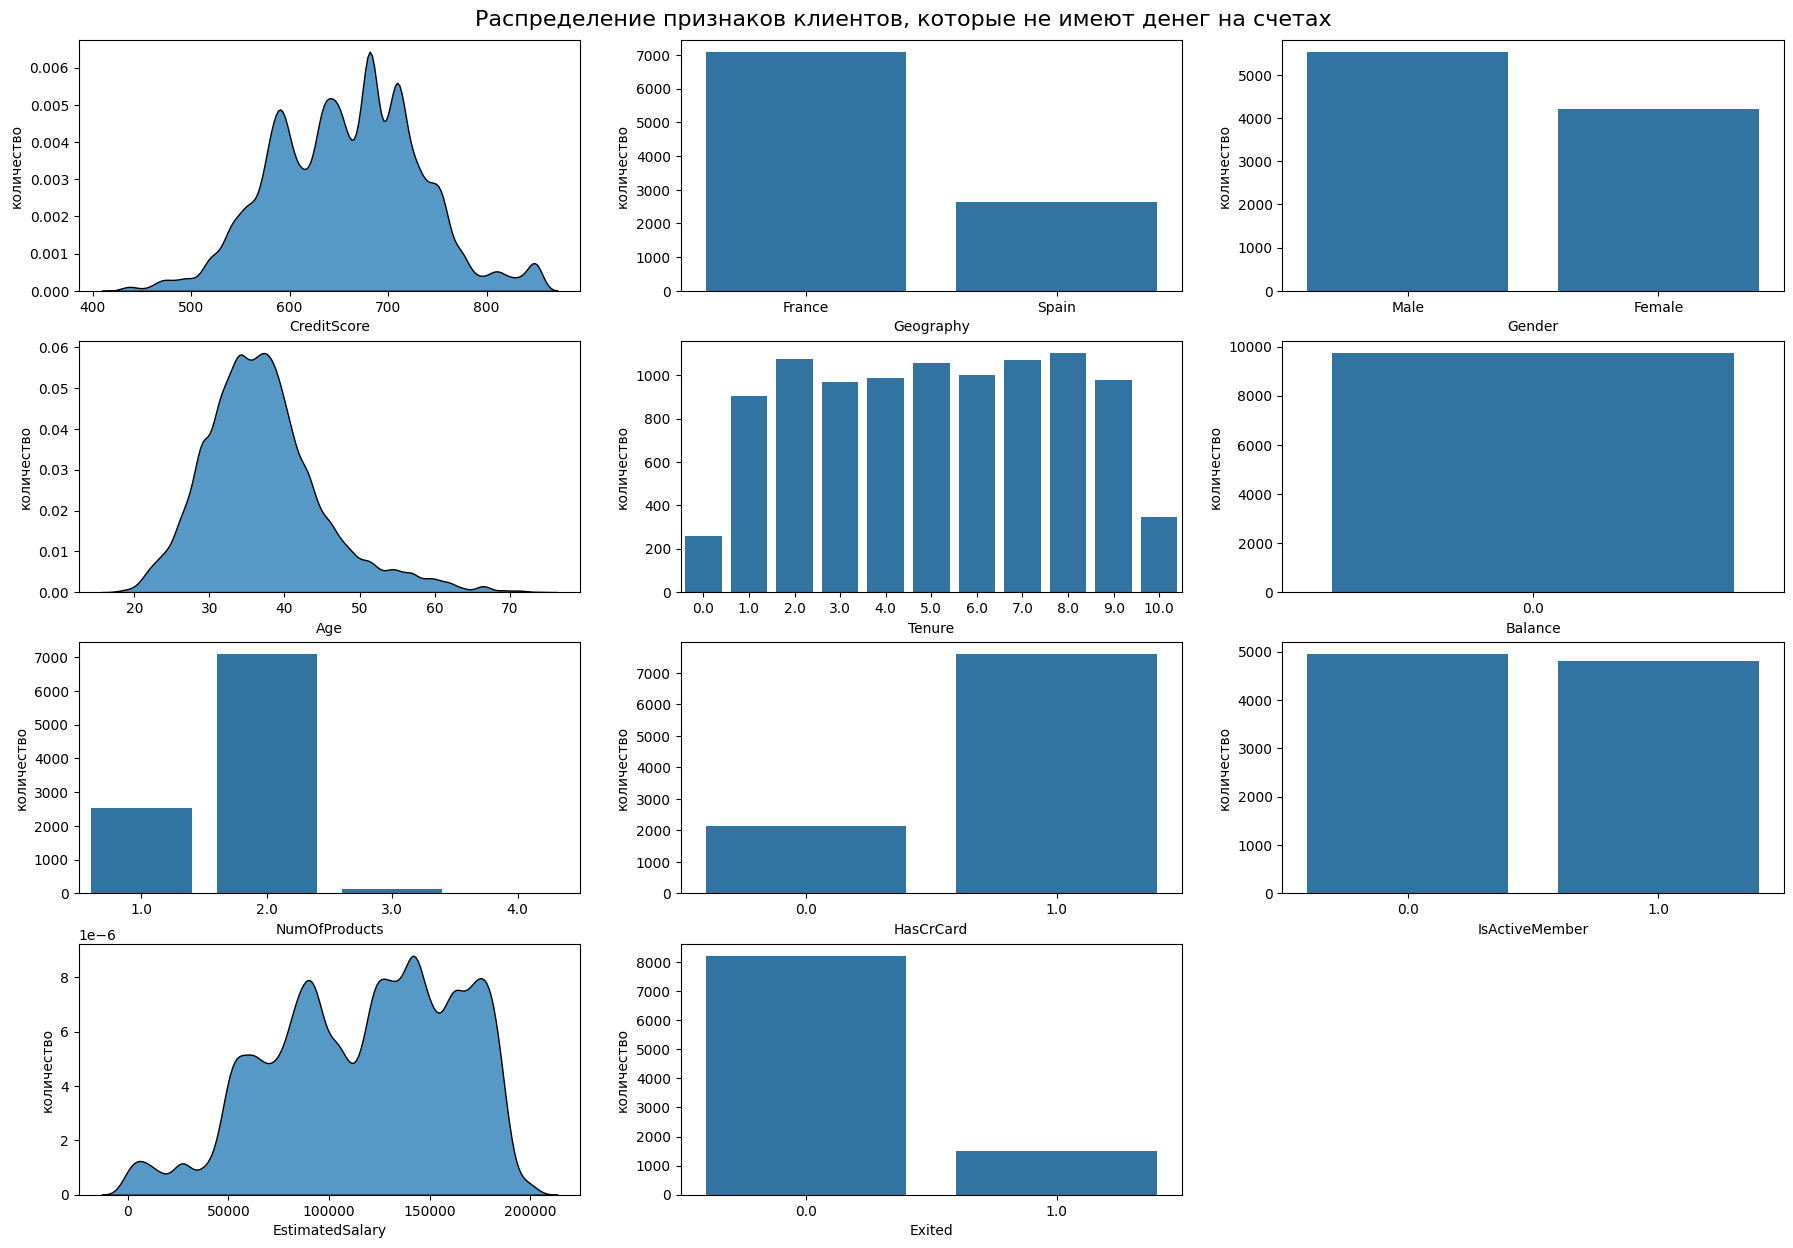

In [16]:
plt_hist(train_customer_churn.query('Balance == 0'))
plt.suptitle('Распределение признаков клиентов, которые не имеют денег на счетах', fontsize=16,y=0.9)
plt.show()

79% клиентов из Франции и 79% клиентов из Испании не хранят деньги на счетах в банке. Все клиенты из Германии имеют баланс на счету. \
Количественный признак, отвечающий за баланс клиентов на счету, является кандидатом на перевод в бинарный категориальный. Необходимо проверить, повлияет ли изменение на качество модели.